In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from string import punctuation
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing
import youtokentome as yttm
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.2.0'

In [3]:
keras.__version__

'2.3.0-tf'

In [4]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [5]:
max_words = 2000
max_len = 50

# Training
epochs = 99150
batch_size = 512
embed_vec_len = 50

In [6]:
exclude = set(punctuation)

In [7]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c if c not in exclude else " " for c in txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = txt.lower()
#     txt = re.sub("\sне", "не", txt)
    return txt

In [8]:
otzivy_za_leto = pd.read_excel("../Lesson_05/отзывы за лето.xls", )
otzivy_za_leto.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [9]:
otzivy_za_leto.Rating.unique()

array([5, 4, 2, 3, 1])

In [10]:
# for to_categorical usage
otzivy_za_leto.Rating = otzivy_za_leto.Rating - 1

In [11]:
otzivy_za_leto.head()

,Rating,Content,Date
0,4,It just works!,2017-08-14
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,4,Отлично все,2017-08-14
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,4,"Очень удобно, работает быстро.",2017-08-14


In [12]:
otzivy_za_leto.Rating.unique()

array([4, 3, 1, 2, 0])

In [13]:
vfunc = np.vectorize(preprocess_text)

In [14]:
%%time
otzivy_za_leto["text"] = vfunc(otzivy_za_leto.Content)
otzivy_za_leto.head()

CPU times: user 348 ms, sys: 52 ms, total: 400 ms
Wall time: 400 ms


,Rating,Content,Date,text
0,4,It just works!,2017-08-14,it just works
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целом удобноное приложение из минусов хотят ...
2,4,Отлично все,2017-08-14,отлично все
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стал зависать на 1 работы антивируса дальше ни...
4,4,"Очень удобно, работает быстро.",2017-08-14,очень удобно работает быстро


In [15]:
train_corpus = " ".join(otzivy_za_leto["text"])
train_corpus = train_corpus.lower()

In [16]:
len(train_corpus)

1136568

In [17]:
train_corpus[:1000]

'it just works в целом удобноное приложение из минусов хотят слишком большой доступ к персональным данным в телефоне приходится пользоваться в ограниченном режиме отлично все стал зависать на 1 работы антивируса дальше никуда ранее больше года пользовался нормально очень удобно работает быстро всё удобно норм очень удобное приложение все устраивает у меня работает все четко в отличии от банкоматов которые вечно зависают и тупят очень все хорошо все ок все нормально кроме того что уведомление нельзя удалять не стартует без доступа к gps sms звонкам и адресной книге филиал фсб одним словом очень удобно работает замечательно подвисаний нет очень удобно очень удобная штука отличное приложение удобно практично очень удобное приложение для оплаты платежей и переводов удобно и быстро очень удобное приложение вот можно было бы транспортные карты пополнять через приложение так вообще замечательно было бы жаль что история всех движений под семью замками хорошее приложение удобно и без лишних хло

In [18]:
train_corpus_filepath = "train_corpus.txt"
with open(train_corpus_filepath, "wt") as out:
    out.write(train_corpus)

In [19]:
# for i in range(20):
#     print(otzivy_za_leto.iloc[i]["Content"],"\n", otzivy_za_leto.iloc[i]["text"], "\n\n")

In [20]:
bpe_model = yttm.BPE.train(data=train_corpus_filepath, vocab_size=max_words, model="model.bpe")

In [21]:
tst_text = "привет как дела мартышка"
encoded = bpe_model.encode(tst_text)
encoded2 = bpe_model.encode(tst_text, output_type=yttm.OutputType.SUBWORD)
print(encoded)
print(encoded2)
print(bpe_model.decode(encoded))

[1686, 310, 531, 710, 11, 322, 29, 169]
['▁привет', '▁как', '▁дела', '▁ма', 'р', 'ты', 'ш', 'ка']
['привет как дела мартышка']


In [22]:
for i in range(10):
    encoded = bpe_model.encode(otzivy_za_leto.iloc[i]["text"])
    print(i, "\'" + otzivy_za_leto.iloc[i]["text"] + "\'", encoded, bpe_model.decode(encoded), "\n", sep="\n\t")

0
	'it just works'
	[1259, 42, 4, 73, 1103, 42, 1133, 1632, 64, 43]
	['it just works']
	

1
	'в целом удобноное приложение из минусов хотят слишком большой доступ к персональным данным в телефоне приходится пользоваться в ограниченном режиме'
	[119, 745, 153, 308, 147, 306, 862, 976, 615, 10, 1653, 876, 30, 439, 141, 516, 12, 525, 145, 671, 825, 671, 119, 609, 496, 492, 119, 966, 578, 20, 325, 360, 379]
	['в целом удобноное приложение из минусов хотят слишком большой доступ к персональным данным в телефоне приходится пользоваться в ограниченном режиме']
	

2
	'отлично все'
	[193, 163]
	['отлично все']
	

3
	'стал зависать на 1 работы антивируса дальше никуда ранее больше года пользовался нормально'
	[1201, 827, 1162, 162, 485, 1440, 644, 1229, 268, 1738, 156, 618, 770, 1546, 1809, 418]
	['стал зависать на 1 работы антивируса дальше никуда ранее больше года пользовался нормально']
	

4
	'очень удобно работает быстро'
	[170, 153, 225, 294]
	['очень удобно работает быстро']
	

5
	'всё удо

In [23]:
def text_to_sequence(text, maxlen):
    result = []
#     tokens = word_tokenize(text.lower())
    tokens = bpe_model.encode(text.lower())
#     tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens:
#         if word in vocabulary:
#             result.append(vocabulary[word])
        result.append(word)
    padding = [0]*(maxlen-len(result))
    if len(padding) >= 1:
        padding[-1] = 2 # <BOS> begin of sentence token
    return padding + result[-maxlen:]

In [24]:
for i in range(10):
    text = otzivy_za_leto.iloc[i]["text"]
    seq = text_to_sequence(text, max_len)
    print(text, seq)

it just works [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1259, 42, 4, 73, 1103, 42, 1133, 1632, 64, 43]
в целом удобноное приложение из минусов хотят слишком большой доступ к персональным данным в телефоне приходится пользоваться в ограниченном режиме [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 119, 745, 153, 308, 147, 306, 862, 976, 615, 10, 1653, 876, 30, 439, 141, 516, 12, 525, 145, 671, 825, 671, 119, 609, 496, 492, 119, 966, 578, 20, 325, 360, 379]
отлично все [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 193, 163]
стал зависать на 1 работы антивируса дальше никуда ранее больше года пользовался нормально [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1201, 827, 1162, 162, 485, 1440, 644, 1229, 268, 1738, 156, 618, 770, 1546, 1809, 418]
очень уд

In [25]:
len(otzivy_za_leto)

20659

In [26]:
otzivy_za_leto = otzivy_za_leto[otzivy_za_leto['Rating'] != 3]
otzivy_za_leto['target'] = otzivy_za_leto['Rating'] > 3
otzivy_za_leto.head()

,Rating,Content,Date,text,target
0,4,It just works!,2017-08-14,it just works,True
2,4,Отлично все,2017-08-14,отлично все,True
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стал зависать на 1 работы антивируса дальше ни...,True
4,4,"Очень удобно, работает быстро.",2017-08-14,очень удобно работает быстро,True
5,4,Всё удобно норм 👍👍👍,2017-08-14,всё удобно норм,True


In [27]:
len(otzivy_za_leto)

18521

In [28]:
otzivy_za_leto['target'] = otzivy_za_leto['target'].astype(int)
otzivy_za_leto.head(15)

,Rating,Content,Date,text,target
0,4,It just works!,2017-08-14,it just works,1
2,4,Отлично все,2017-08-14,отлично все,1
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стал зависать на 1 работы антивируса дальше ни...,1
4,4,"Очень удобно, работает быстро.",2017-08-14,очень удобно работает быстро,1
5,4,Всё удобно норм 👍👍👍,2017-08-14,всё удобно норм,1
6,4,Очень удобное приложение.,2017-08-14,очень удобное приложение,1
7,4,Все устраивает,2017-08-14,все устраивает,1
8,4,У меня работает все четко. В отличии от банком...,2017-08-14,у меня работает все четко в отличии от банкома...,1
9,4,Очень все хорошо👍,2017-08-14,очень все хорошо,1
10,4,Все ок!,2017-08-14,все ок,1


In [29]:
num_classes = len(otzivy_za_leto["target"].unique())
num_classes

2

In [30]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in otzivy_za_leto["text"]], dtype=np.int32)

In [31]:
x_train[-15]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   2, 428,   7, 159, 172], dtype=int32)

In [32]:
bpe_model.vocab()[:200]

['<PAD>',
 '<UNK>',
 '<BOS>',
 '<EOS>',
 '▁',
 'о',
 'е',
 'н',
 'а',
 'и',
 'т',
 'р',
 'с',
 'л',
 'в',
 'п',
 'д',
 'у',
 'б',
 'к',
 'м',
 'ь',
 'ч',
 'я',
 'ж',
 'з',
 'ы',
 'г',
 'х',
 'ш',
 'й',
 'ю',
 'ц',
 'ф',
 'ё',
 'э',
 'щ',
 'o',
 'e',
 'i',
 'a',
 'r',
 't',
 's',
 'm',
 'n',
 '0',
 'u',
 '2',
 '5',
 '1',
 'l',
 'd',
 'p',
 '3',
 '4',
 'z',
 'g',
 'y',
 'c',
 'h',
 '6',
 'f',
 'x',
 'k',
 'w',
 '7',
 'b',
 'v',
 '9',
 '8',
 'q',
 'ъ',
 'j',
 'ј',
 'і',
 '好',
 'い',
 'د',
 'ج',
 'ա',
 'ө',
 'š',
 'č',
 'è',
 '软',
 '的',
 '用',
 '物',
 '挺',
 '很',
 '件',
 'っ',
 'だ',
 'ぜ',
 'こ',
 'か',
 'ي',
 'ا',
 'պ',
 'ո',
 'յ',
 'հ',
 'կ',
 'է',
 'џ',
 'ў',
 'ћ',
 'ї',
 'є',
 'ѓ',
 'ђ',
 'ω',
 'ö',
 'ó',
 'ä',
 '▁п',
 'но',
 'ен',
 '▁в',
 '▁н',
 '▁о',
 '▁пр',
 '▁с',
 'ра',
 'ло',
 '▁у',
 'то',
 'ет',
 'ени',
 'до',
 '▁при',
 '▁по',
 '▁и',
 'та',
 '▁не',
 'лож',
 'ложени',
 '▁приложени',
 'ер',
 'ть',
 '▁к',
 'бно',
 '▁вс',
 'ро',
 'ль',
 '▁м',
 '▁приложение',
 'ли',
 '▁удо',
 'бо',
 'за',
 'хо

In [33]:
bpe_model.decode(x_train[-15].tolist())

['<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><BOS> удобненько']

In [34]:
y_train = keras.utils.to_categorical(otzivy_za_leto["target"], num_classes)

In [35]:
for i, rec in enumerate(y_train[:20].tolist()):
    print(i, otzivy_za_leto.iloc[i]["target"], rec)

0 1 [0.0, 1.0]
1 1 [0.0, 1.0]
2 1 [0.0, 1.0]
3 1 [0.0, 1.0]
4 1 [0.0, 1.0]
5 1 [0.0, 1.0]
6 1 [0.0, 1.0]
7 1 [0.0, 1.0]
8 1 [0.0, 1.0]
9 1 [0.0, 1.0]
10 1 [0.0, 1.0]
11 0 [1.0, 0.0]
12 1 [0.0, 1.0]
13 1 [0.0, 1.0]
14 1 [0.0, 1.0]
15 1 [0.0, 1.0]
16 1 [0.0, 1.0]
17 1 [0.0, 1.0]
18 1 [0.0, 1.0]
19 1 [0.0, 1.0]


In [36]:
keras.backend.clear_session()



X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_")(X_input)
Drop1 = tf.keras.layers.Dropout(0.2)(Embed_)
BGRU_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, return_sequences=False, dropout=0.25, recurrent_dropout=0.25, activation="relu", implementation=2, name="GRU_1", stateful=False), name="BGRU_1")(Drop1)
Drop2 = tf.keras.layers.Dropout(0.3)(BGRU_1)
Dense_1 = tf.keras.layers.Dense(units=16, activation='relu', name="Dense_1")(Drop2)
Drop3 = tf.keras.layers.Dropout(0.4)(Dense_1)
Dense_2 = tf.keras.layers.Dense(units=16, activation='relu', name="Dense_2")(Dense_1)
Drop4 = tf.keras.layers.Dropout(0.5)(Dense_2)

y_output = tf.keras.layers.Dense(units=num_classes, activation="softmax", name="y")(Dense_2)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 50)]              0         
_________________________________________________________________
Embed_ (Embedding)           (None, 50, 50)            100000    
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
BGRU_1 (Bidirectional)       (None, 32)                6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                272

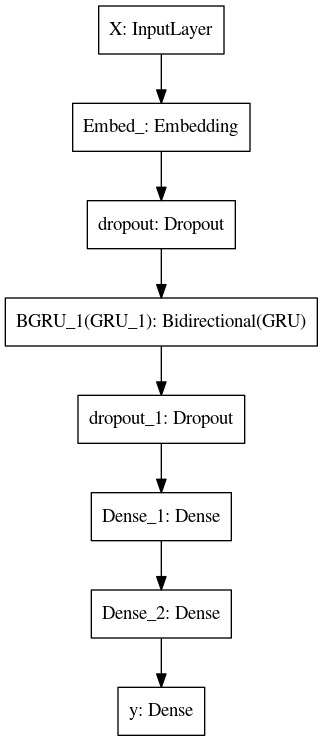

In [38]:
tf.keras.utils.plot_model(model)

In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=1,
                            verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=10,
                                           verbose=1,
                                           factor=0.75,
                                           min_lr=0.00000001)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[checkpoint, early_stopping_callback, learning_rate_reduction])

Epoch 1/99150
29/29 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.8099
Epoch 00001: val_accuracy improved from -inf to 0.68961, saving model to best_model.h5
29/29 [==============================] - 4s 132ms/step - loss: 0.6123 - accuracy: 0.8099 - val_loss: 0.5910 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 2/99150
29/29 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8120
Epoch 00002: val_accuracy did not improve from 0.68961
29/29 [==============================] - 3s 118ms/step - loss: 0.4334 - accuracy: 0.8120 - val_loss: 0.5568 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 3/99150
29/29 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8120
Epoch 00003: val_accuracy did not improve from 0.68961
29/29 [==============================] - 3s 118ms/step - loss: 0.3283 - accuracy: 0.8120 - val_loss: 0.3994 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 4/99150
29/29 [==============================] - ETA: 0s - loss: 0.2557 - 

29/29 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9720
Epoch 00027: val_accuracy did not improve from 0.92065
29/29 [==============================] - 4s 122ms/step - loss: 0.0899 - accuracy: 0.9720 - val_loss: 0.2942 - val_accuracy: 0.9109 - lr: 7.5000e-04
Epoch 28/99150
29/29 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9724
Epoch 00028: val_accuracy did not improve from 0.92065
29/29 [==============================] - 4s 121ms/step - loss: 0.0874 - accuracy: 0.9724 - val_loss: 0.2847 - val_accuracy: 0.9131 - lr: 7.5000e-04
Epoch 29/99150
29/29 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9726
Epoch 00029: val_accuracy did not improve from 0.92065
29/29 [==============================] - 3s 118ms/step - loss: 0.0875 - accuracy: 0.9726 - val_loss: 0.2852 - val_accuracy: 0.9144 - lr: 7.5000e-04
Epoch 30/99150
29/29 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9738
Epoch 00030: v

Epoch 54/99150
29/29 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9800
Epoch 00054: val_accuracy did not improve from 0.92065
29/29 [==============================] - 3s 118ms/step - loss: 0.0672 - accuracy: 0.9800 - val_loss: 0.3472 - val_accuracy: 0.9101 - lr: 3.1641e-04
Epoch 55/99150
29/29 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9790
Epoch 00055: val_accuracy did not improve from 0.92065
29/29 [==============================] - 3s 118ms/step - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.3490 - val_accuracy: 0.9082 - lr: 3.1641e-04
Epoch 56/99150
29/29 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9783
Epoch 00056: val_accuracy did not improve from 0.92065
29/29 [==============================] - 3s 118ms/step - loss: 0.0711 - accuracy: 0.9783 - val_loss: 0.3416 - val_accuracy: 0.9090 - lr: 3.1641e-04
Epoch 57/99150
29/29 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9792

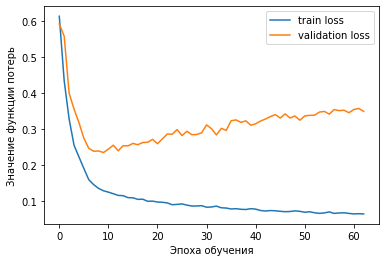

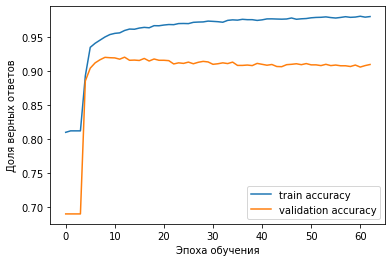

In [40]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()